# Title of the thing

This is where I would put additional explanations if I knew what I want to say. 

## The AOMIC Data

First, lets load the data and inspect it a bit. The [AOMIC dataset](https://nilab-uva.github.io/AOMIC.github.io/) is a collection data obtained in three different studies (**PIOP1**, **PIOP2**, **ID1000**). Here, we will be only concerned with the data from the **ID1000** study, which aimed to collect 1000 fMRI scans during movie-watching. The next cell defines the path to all the **ID1000** specific data, and also adds the names of the two files we will be interested in. One of these files contains the preprocessed **functional connectivity (FC)** data, whereas the other file contains the important **demographic** information. Let's start by also loading the dependencies:

In [1]:
import pandas as pd
from pathlib import Path

In [2]:
# Path to ID1000 data within the AOMIC datalad dataset
ID1000_path = (
    Path("..") / "aomic-fc"/ "junifer_storage" / 
    "JUNIFER_AOMIC_TSV_CONNECTOMES" / "ID1000"
)

# Path to the demographics data file
demographics_path = ID1000_path / "ID1000_participants.tsv"

# Path to the connectomes data file
# The name of this file is a bit of a mouthful but contains important
# information
connectomes_path = ID1000_path / (
    "ID1000_BOLD_parccortical-Schaefer100x17FSLMNI_"
    "parcsubcortical-TianxS2x3TxMNInonlinear2009cAsym_"
    "marker-empiricalFC_moviewatching.tsv.gz"
)

### Demographic Data

Now that we have defined these paths let's load each file and look at them one by one. Let's start with the demographics. We will load it using pandas, and as you might see from the file extension, these are both **tsv** files and we will therefore load them using a tab as a delimiter. In addition, we will load the first column as the index of the dataframe as it happens to contain the subject ID's.

In [3]:
demographics = pd.read_csv(demographics_path, sep="\t", index_col=0)
demographics

,age,sex,handedness,BMI,education_level,background_SES,IST_fluid,IST_memory,IST_crystallised,IST_intelligence_total,...,sexual_attraction_M,sexual_attraction_F,gender_identity_M,gender_identity_F,religious_upbringing,religious_now,religious_importance,DWI_TR_run1,DWI_TR_run2,DWI_TR_run3
participant_id,,,,,,,,,,,,,,,,,,,,,
sub-0001,22.00,female,right,23,medium,2.0,77.0,49.0,33.0,159.0,...,7.0,1.0,1.0,7.0,no,yes,2.0,6.312,6.312,6.312
sub-0002,21.75,female,right,20,medium,5.5,97.0,63.0,39.0,199.0,...,7.0,1.0,2.0,7.0,no,no,NaN,NaN,6.311,6.311
sub-0003,25.25,female,right,31,high,3.0,122.0,67.0,38.0,227.0,...,6.0,3.0,1.0,6.0,no,no,NaN,6.312,6.312,6.312
sub-0004,22.50,female,right,20,high,5.0,149.0,69.0,52.0,270.0,...,6.0,2.0,1.0,7.0,yes,no,NaN,6.311,6.311,6.311
sub-0005,22.25,male,right,23,high,4.5,112.0,57.0,43.0,212.0,...,1.0,7.0,6.0,1.0,no,no,NaN,6.311,6.311,6.311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-0924,22.25,male,right,21,medium,3.0,136.0,56.0,54.0,246.0,...,2.0,6.0,4.0,4.0,no,no,NaN,6.374,6.374,6.374
sub-0925,25.25,male,right,30,medium,4.0,64.0,37.0,49.0,150.0,...,1.0,7.0,7.0,1.0,no,no,NaN,6.311,6.311,6.311
sub-0926,20.75,male,right,22,high,2.0,84.0,44.0,33.0,161.0,...,NaN,NaN,NaN,NaN,yes,yes,5.0,6.312,6.312,6.312


We can see some of the standard demographic variables, like "age", "sex", "BMI", and so on. As you might be able to tell, however, this file not *only* contains "demographic" information but also some other participant data, as for example cognitive measurements (e.g. "IST_memory", "IST_fluid").

### Connectomes

Let us now check the connectomes out to see for which subjects we have preprocessed functional connectivity data available.

In [4]:
connectomes = pd.read_csv(connectomes_path, sep="\t", index_col=0, compression="gzip")
connectomes

,LH_VisCent_ExStr_2~LH_VisCent_ExStr_1,LH_VisCent_Striate_1~LH_VisCent_ExStr_1,LH_VisCent_Striate_1~LH_VisCent_ExStr_2,LH_VisCent_ExStr_3~LH_VisCent_ExStr_1,LH_VisCent_ExStr_3~LH_VisCent_ExStr_2,LH_VisCent_ExStr_3~LH_VisCent_Striate_1,LH_VisPeri_ExStrInf_1~LH_VisCent_ExStr_1,LH_VisPeri_ExStrInf_1~LH_VisCent_ExStr_2,LH_VisPeri_ExStrInf_1~LH_VisCent_Striate_1,LH_VisPeri_ExStrInf_1~LH_VisCent_ExStr_3,...,pCAU-lh~THA-VP-lh,pCAU-lh~THA-VA-lh,pCAU-lh~THA-DA-lh,pCAU-lh~NAc-shell-lh,pCAU-lh~NAc-core-lh,pCAU-lh~pGP-lh,pCAU-lh~aGP-lh,pCAU-lh~aPUT-lh,pCAU-lh~pPUT-lh,pCAU-lh~aCAU-lh
sub-0001,0.533892,0.638701,0.560450,0.789158,0.466875,0.539399,0.677232,0.366597,0.361958,0.564919,...,0.072425,0.366347,0.327794,-0.069095,0.468919,-0.071477,0.040889,0.212324,0.173870,0.664122
sub-0002,0.641335,0.663375,0.545326,0.629451,0.187963,0.390782,0.670098,0.116997,0.397939,0.742349,...,-0.048029,0.294397,0.247182,0.050190,0.069237,-0.133454,0.011535,0.265424,0.147957,0.587463
sub-0003,0.657928,0.742613,0.453348,0.860049,0.523853,0.591320,0.770457,0.418997,0.645827,0.725303,...,-0.145307,0.240758,-0.014584,0.125811,0.397896,0.112837,0.292399,0.473047,0.224996,0.711400
sub-0004,0.788957,0.694655,0.660015,0.732351,0.517771,0.387978,0.620954,0.283812,0.426040,0.622988,...,0.288743,0.276673,0.355181,0.250076,0.216825,-0.064241,0.045752,0.379170,0.226584,0.388584
sub-0005,0.594372,0.761742,0.667648,0.791777,0.467393,0.515712,0.285025,-0.306764,0.179985,0.250133,...,-0.009222,0.393067,0.032954,0.220143,0.289458,0.012017,0.073975,0.515776,0.426828,0.701249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-0923,0.580657,0.581537,0.456695,0.852308,0.345382,0.325712,0.656729,0.186045,0.466766,0.692227,...,0.356343,0.386007,0.461522,-0.158422,0.364220,-0.159627,-0.157892,0.505149,0.343721,0.622666
sub-0924,0.772896,0.576773,0.382912,0.857393,0.595229,0.373345,0.384935,0.119016,0.407748,0.466081,...,-0.001937,0.384416,0.317110,-0.004191,0.178207,-0.105206,0.375226,0.427756,0.441114,0.711478
sub-0925,0.836000,0.674962,0.643015,0.708971,0.593741,0.415912,0.240876,0.030883,0.435190,0.354092,...,-0.123305,0.391051,0.101072,0.482087,0.363243,0.259769,0.127300,0.283468,0.446741,0.472104
sub-0926,0.699854,0.751275,0.615963,0.834274,0.421496,0.565254,0.829891,0.371156,0.578320,0.874583,...,0.179298,0.550858,0.605740,0.030332,0.411371,0.123619,0.216562,0.465273,0.301320,0.666110


In this dataframe again, **each row** corresponds to *one subject* from the study. **Each column** represents a *unique pairwise relationship* between two brain areas (also called an *edge* in graph theory terminology). That is, since a brain parcellation with **N** areas results in an **NxN** symmetric correlation matrix per subject, one half of a subjects matrix is discarded. Similarly, the diagonal of this correlation matrix is also typically discarded as the correlation of an area with itself is always 1. The remaining entries can be stacked and result in one row of this dataframe. Thus, each row contains **N x (N-1) / 2** entries. In our case, since the connectomes were processed with a combination of the Schaefer 100 cortical parcellation and the Tian 32 subcortical parcellation, this results in **100 x (100 - 1) / 2 = 8646** columns. This concept is illustrated by the graphic below:

![title](images/connectomes.png)


### Subsetting the data

As you can see, the first dataframe on demographics contains 928 rows (i.e. subjects), whereas the second dataframe contains 877 rows. Let us for further analyses only select subjects for which we actually have connectomes. But first, let's also make sure, that we identify any 'NaN' values in the functional connectivity data and remove subjects with any 'NaN' entries.

The pandas **isna()** method will check for each entry in the dataframe whether it is 'NaN' or not. That is, if an entry is 'NaN' it will return True and otherwise it will return False. We can use this to identify the indices (i.e. subjects) for which there are 'NaN' entries by combining it with the **any()** method provided by pandas.

First see the output from **isna()**:

In [5]:
isna = connectomes.isna()
isna

,LH_VisCent_ExStr_2~LH_VisCent_ExStr_1,LH_VisCent_Striate_1~LH_VisCent_ExStr_1,LH_VisCent_Striate_1~LH_VisCent_ExStr_2,LH_VisCent_ExStr_3~LH_VisCent_ExStr_1,LH_VisCent_ExStr_3~LH_VisCent_ExStr_2,LH_VisCent_ExStr_3~LH_VisCent_Striate_1,LH_VisPeri_ExStrInf_1~LH_VisCent_ExStr_1,LH_VisPeri_ExStrInf_1~LH_VisCent_ExStr_2,LH_VisPeri_ExStrInf_1~LH_VisCent_Striate_1,LH_VisPeri_ExStrInf_1~LH_VisCent_ExStr_3,...,pCAU-lh~THA-VP-lh,pCAU-lh~THA-VA-lh,pCAU-lh~THA-DA-lh,pCAU-lh~NAc-shell-lh,pCAU-lh~NAc-core-lh,pCAU-lh~pGP-lh,pCAU-lh~aGP-lh,pCAU-lh~aPUT-lh,pCAU-lh~pPUT-lh,pCAU-lh~aCAU-lh
sub-0001,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sub-0002,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sub-0003,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sub-0004,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sub-0005,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-0923,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sub-0924,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sub-0925,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sub-0926,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


The **any()** method will return whether any element along a given axis (i.e. along a row or a column) is True. The following output should be "True" therefore, if a subject has 'NaN' values and "False" otherwise:

In [6]:
isna_any = isna.any(axis=1)
isna_any

sub-0001    False
sub-0002    False
sub-0003    False
sub-0004    False
sub-0005    False
            ...  
sub-0923    False
sub-0924    False
sub-0925    False
sub-0926    False
sub-0927    False
Length: 877, dtype: bool

We can do calculations on these boolean values as if they are 0's and 1's. That is, "True" will be counted as 1 and "False" will be counted as 0. We can therefore use the **.sum()** method to determine the number of 'NaN' values:

In [7]:
isna_any.sum()

0

The output ("0") shows us that there aren't any 'NaN' values, so we can simply proceed with the data we have here. Let us therefore now subset the demographic data for which we have connectomes. That is, we will index the demographics dataset using the index from the connectomes dataset:

In [8]:
subsampled_demographics = demographics.loc[connectomes.index]
subsampled_demographics

,age,sex,handedness,BMI,education_level,background_SES,IST_fluid,IST_memory,IST_crystallised,IST_intelligence_total,...,sexual_attraction_M,sexual_attraction_F,gender_identity_M,gender_identity_F,religious_upbringing,religious_now,religious_importance,DWI_TR_run1,DWI_TR_run2,DWI_TR_run3
sub-0001,22.00,female,right,23,medium,2.0,77.0,49.0,33.0,159.0,...,7.0,1.0,1.0,7.0,no,yes,2.0,6.312,6.312,6.312
sub-0002,21.75,female,right,20,medium,5.5,97.0,63.0,39.0,199.0,...,7.0,1.0,2.0,7.0,no,no,NaN,NaN,6.311,6.311
sub-0003,25.25,female,right,31,high,3.0,122.0,67.0,38.0,227.0,...,6.0,3.0,1.0,6.0,no,no,NaN,6.312,6.312,6.312
sub-0004,22.50,female,right,20,high,5.0,149.0,69.0,52.0,270.0,...,6.0,2.0,1.0,7.0,yes,no,NaN,6.311,6.311,6.311
sub-0005,22.25,male,right,23,high,4.5,112.0,57.0,43.0,212.0,...,1.0,7.0,6.0,1.0,no,no,NaN,6.311,6.311,6.311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-0923,21.75,male,right,19,medium,3.0,70.0,49.0,34.0,153.0,...,1.0,7.0,7.0,1.0,no,no,NaN,6.733,6.733,6.733
sub-0924,22.25,male,right,21,medium,3.0,136.0,56.0,54.0,246.0,...,2.0,6.0,4.0,4.0,no,no,NaN,6.374,6.374,6.374
sub-0925,25.25,male,right,30,medium,4.0,64.0,37.0,49.0,150.0,...,1.0,7.0,7.0,1.0,no,no,NaN,6.311,6.311,6.311
sub-0926,20.75,male,right,22,high,2.0,84.0,44.0,33.0,161.0,...,NaN,NaN,NaN,NaN,yes,yes,5.0,6.312,6.312,6.312


The indexing using the **.loc()** method importantly also ensures that the rows in both dataframes are in the same order which will be important later when we convert them to numpy arrays, a data structure that scikit-learn understands.

### Exploring our sample:

Now that the samples in the connectome data and the demographics data are matched, let's take a quick look at sex and age to get an overview of our sample.

The **value_counts()** method takes a pandas series (i.e. a column from the dataframe) and counts the amount of times each possible value is contained in the column. This is a good way of discovering what values are possible for a specific variable, and how many instances there are for each value. This is useful for example when looking at the sex information of a sample:

In [9]:
subsampled_demographics["sex"].value_counts()

female    454
male      423
Name: sex, dtype: int64

The **plot.hist()** pandas method provides a quick way of making a histogram that we can also group by "sex" to look at each distribution seperately: 

array([<AxesSubplot: title={'center': 'female'}, ylabel='Frequency'>,
       <AxesSubplot: title={'center': 'male'}, ylabel='Frequency'>],
      dtype=object)

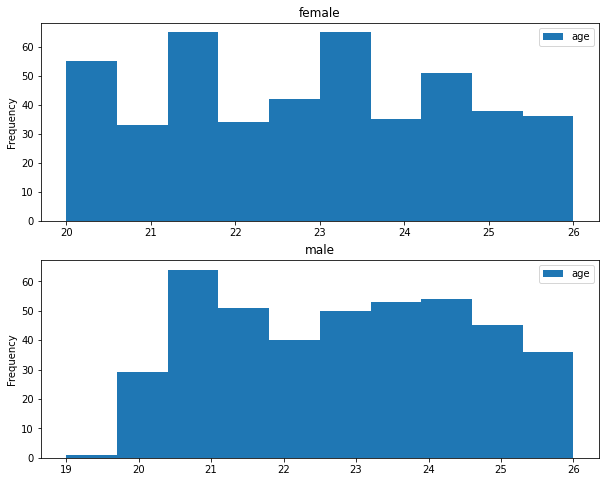

In [10]:
subsampled_demographics.plot.hist(column=["age"], by="sex", figsize=(10, 8))

As you can see, the age range is quite narrow, and limited to young people. This is a common problem in neuroimaging or psychology studies, which often sample students from their universities for convenience. It is always good to be aware of these limitations before starting any complicated machine learning pipeline.

## Doing some ML

Now, lets try to build a classifier that can distinguish between males and females given a functional connectome. That is, the connectomes will be the features ('X') and the sex will be the target ('y'). Since "sex" in our data is encoded as "male" and "female" and scikit-learn only understands numeric data, we have to convert "sex" to a numeric, categorial variable. Since it's a binary target, this is relatively straightforward. We can do this simply by adding another column to our demographics data as follows:


In [11]:
subsampled_demographics["sex_numeric"] = subsampled_demographics["sex"].map(lambda x: 1 if x == "female" else 0)

We can inspect the output as follows:


In [12]:
sex_info = subsampled_demographics[["sex", "sex_numeric"]]
sex_info

,sex,sex_numeric
sub-0001,female,1
sub-0002,female,1
sub-0003,female,1
sub-0004,female,1
sub-0005,male,0
...,...,...
sub-0923,male,0
sub-0924,male,0
sub-0925,male,0
sub-0926,male,0


As you can see, there is a 1 where sex is given as "female" and a 0 where sex is given as male. Let's finalise the target as a numpy array which is a data structure scikit-learn understands:

In [13]:
import numpy as np

y = np.array(sex_info["sex_numeric"])
y

array([1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,

### Train-test split

Let us first split the data so we have one hold-out validation set that will be left untouched for now. Let us also finalise our features as a numpy array:

In [14]:
from sklearn.model_selection import train_test_split

X = np.array(connectomes)

X_model_selection, X_holdout, y_model_selection, y_holdout = train_test_split(X, y, random_state=1000)

We will then do another train-test split on the model selection data, so that we can train models on the inner training set, compare their performance on the inner test set, and then evaluate our final model on the hold-out validation set.

In [15]:
X_inner_train, X_inner_test, y_inner_train, y_inner_test = \
    train_test_split(X_model_selection, y_model_selection, random_state=1000)

### Fitting a bunch of models

Every problem, every classification or regression task is different, and therefore requires a different model. That is, which model works best depends on the underlying processes that generate the distribution of our X and on the "true" function that maps X to y. In other words, we cannot really know which model will work best before we try it out. Let us test out a few popular options therefore starting with **Logistic Regression**. Now, although it is called **Logistic Regression** this is actually a classifier.

In [16]:
from sklearn.linear_model import LogisticRegression

We can initialise the LogisticRegression object, and then fit it on the training data:

In [17]:
logistic_regression = LogisticRegression(max_iter=1000)

In [18]:
logistic_regression.fit(X_inner_train, y_inner_train)

LogisticRegression(max_iter=1000)

We can now test the accuracy of this classifier by making predictions on our test set that was so far unseen. The predictions can then be compared to the true values of y in this test set using some metric (for example "accuracy" in our case):

In [19]:
predictions_log_reg = logistic_regression.predict(X_inner_test)

In [20]:
predictions_log_reg

array([0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1])

In [21]:
y_inner_test

array([1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0])

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
accuracy_score(y_inner_test, predictions_log_reg)

0.806060606060606